# Vehicle Detection

The Goal: Create a pipeline that detects cars in a video stream.

## Import Important Implementations

In [1]:
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Conv2D, MaxPooling2D, Input

%matplotlib inline
import matplotlib.pylab as plt

Using TensorFlow backend.


## Load Likeness Lots

### Augment Appearances

Here I define a function that given an image returns a set of 4 images, the original image, the original image flipped & the two previous images zoomed in on a random part of the image.  This helps the network better detect cars both in the foreground and the background.

In [2]:
def random_zoom(img):

    zoom_width = np.random.randint(32, 48)
    zoom_x_offset = np.random.randint(0, 64-zoom_width)
    zoom_y_offset = np.random.randint(0, 64-zoom_width)

    zoomed = cv2.resize(
        img[zoom_x_offset:zoom_x_offset+zoom_width, zoom_y_offset:zoom_y_offset+zoom_width], 
        (img.shape[1], img.shape[0])
    )
    
    return zoomed
def agument(img):
    img_flipped = cv2.flip(img, 1)
    zoomed = random_zoom(img)
    zoomed_flipped = random_zoom(img_flipped)
    
    return img, img_flipped, zoomed, zoomed_flipped

### Load Lots

The images are loaded and agumented into `features` and labels are created and added to `labels`

In [3]:
# TODO: turn this into a generator so all the images don't have to be loaded at once.

cars = glob.glob('./vehicles/*/*.png')
non_cars = glob.glob('./non-vehicles/*/*.png')

# Load Car Pictures
car_features = []
for path in cars:
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    car_features.extend(agument(img))
    
car_features = np.array(car_features)
# Set Car labels to 1s
car_labels = np.ones(car_features.shape[0])

# Load Non-Car Pictures
non_car_features = []
for path in non_cars:
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    non_car_features.extend(agument(img))
    
non_car_features = np.array(non_car_features)
non_car_labels = np.zeros(non_car_features.shape[0]) - 1

features = np.concatenate((car_features, non_car_features))
labels = np.concatenate((car_labels, non_car_labels))

print('Car shape: {}\nNon-car shape: {}\n\nFeature shape: {}\nLabel shape: {}'.format(
    car_features.shape, 
    non_car_features.shape, 
    features.shape, 
    labels.shape
))

Car shape: (35168, 64, 64, 3)
Non-car shape: (35872, 64, 64, 3)

Feature shape: (71040, 64, 64, 3)
Label shape: (71040,)


### Example Exhibit

A random image from the dataset is shown along with it's label.  (run this box multiple times to see more than one image)

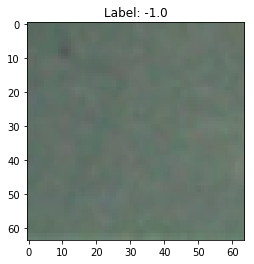

In [4]:
idx = np.random.randint(features.shape[0])
plt.title('Label: {}'.format(labels[idx]))
plt.imshow(features[idx])
plt.show()

## Split Segments

The training, testing, and validation sets are split.

In [5]:
features_train, features_test, labels_train,labels_test = train_test_split(
    features, 
    labels, 
    test_size=0.2, 
    random_state=1
)

features_val, features_test, labels_val, labels_test = train_test_split(
    features_test, 
    labels_test, 
    test_size=0.5, 
    random_state=1
)

print('Train Size: {}\nVal Size:   {}\nTest Size:  {}'.format(
    features_train.shape[0],
    features_val.shape[0],
    features_test.shape[0]
))


Train Size: 56832
Val Size:   7104
Test Size:  7104


## Define Model

The Neural Network is defined here.

_Attribute: The idea for using a Conv network like this came from [this github](https://github.com/HTuennermann/Vehicle-Detection-and-Tracking), but I implemented it from scratch._

In [6]:
import tensorflow as tf
tf.reset_default_graph()

def create_model(general=False, drop_rate=0.25):
    
    np.random.seed(42)
    
    if general:
        in_layer = Input(shape=(None, None, 3))
    else:
        in_layer = Input(shape=(64, 64, 3))
    
    #in_layer = Input(shape=shape)
    x = Lambda(lambda x: x/127. - 1.)(in_layer)
    x = Conv2D(16,  (5, 5), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32,  (5, 5), activation='elu', padding='valid')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='valid')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32,  (3, 3), activation='elu', padding='valid')(x)
    x = Dropout(drop_rate)(x)
    x = Conv2D(16,  (3, 3), activation='elu', padding='valid')(x)
    x = Dropout(drop_rate)(x)
    x = Conv2D(1,   (2, 2), activation="tanh")(x)
    
    return in_layer, x

# in_layer, out_layer = create_model()
# Model(in_layer, out_layer).summary()

## Train Model

The network is then trained on the data loaded/augmented earlier.

In [7]:
in_layer, out_layer = create_model()
out_layer = Flatten()(out_layer)

model = Model(in_layer, out_layer)

model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.fit(features_train, labels_train, batch_size=256, epochs=10, validation_data=(features_val, labels_val))

print('Test accuracy:', model.evaluate(features_test, labels_test, verbose=0)[1])
model.save_weights('model.h5')

Train on 56832 samples, validate on 7104 samples
Epoch 1/10
56832/56832 [==============================] - 308s 5ms/step - loss: 0.3067 - acc: 0.7688 - val_loss: 0.1320 - val_acc: 0.9229
Epoch 2/10
56832/56832 [==============================] - 312s 5ms/step - loss: 0.1078 - acc: 0.9353 - val_loss: 0.1025 - val_acc: 0.9419
Epoch 3/10
56832/56832 [==============================] - 305s 5ms/step - loss: 0.0961 - acc: 0.9476 - val_loss: 0.1589 - val_acc: 0.9195
Epoch 4/10
56832/56832 [==============================] - 305s 5ms/step - loss: 0.0801 - acc: 0.9568 - val_loss: 0.0824 - val_acc: 0.9599
Epoch 5/10
56832/56832 [==============================] - 296s 5ms/step - loss: 0.0746 - acc: 0.9606 - val_loss: 0.0892 - val_acc: 0.9579
Epoch 6/10
56832/56832 [==============================] - 295s 5ms/step - loss: 0.0727 - acc: 0.9621 - val_loss: 0.0687 - val_acc: 0.9641
Epoch 7/10
56832/56832 [==============================] - 294s 5ms/step - loss: 0.0635 - acc: 0.9663 - val_loss: 0.0566 - v

### Example Exhibit

A random image from the testing set is run through the network to get a prediction.

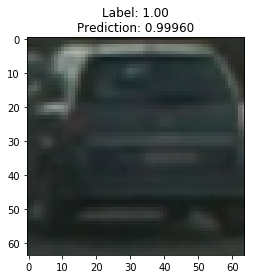

In [8]:
idx = np.random.randint(features_test.shape[0])
img = np.array([features_test[idx]])

plt.title('Label: {:0.2f}\nPrediction: {:0.5f}'.format(labels_test[idx], model.predict(img)[0][0]))
plt.imshow(features_test[idx])
plt.show()

### Define get_heatmap Function

This function runs the same model as before, however instead of running it on the 64x64 images and predicting 1 value, it runs it accross the entire image and produces a heatmap of how "car" like each part of the image is.

In [9]:
in_layer, out_layer = create_model(general=True)
model = Model(in_layer, out_layer)
model.load_weights('model.h5')

def get_heatmap(img):
    return model.predict(np.array([img]))[0,:,:,0]

### Define box_scale Function

This function is used to scale up the heatmap.

In [10]:
### Not used anymore
# def box_scale(img, box_size=32, scale=8, margin=32):
#     scaled = np.zeros(shape=(img.shape[0]*scale+margin*2, img.shape[1]*scale+margin*2)).astype('float32')
#     for (x, y), value in np.ndenumerate(img):
#         x = (x*scale)+margin
#         y = (y*scale)+margin
#         if value > 0:
#             scaled[x-box_size:x+box_size, y-box_size:y+box_size] += value
#     return scaled

### Define get_labels Function

`get_labels` on the surface is a wrapper for `scipy.ndimage.measurements.label` but it actually does a little more than that, it allows me to specify what the highest point in a label needs to be (`thresh`) in order to label it & it allows me to specify at what threshold the image should be cut (I.e. how low must the valies be between two points to be classified as different mountains.)

In [11]:
from scipy.ndimage.measurements import label

def get_labels(img, thresh=32, crop_thresh=8, size_min=(20, 20), size_max=(330, 330)):
    img = img.copy()
    img[img < crop_thresh] = 0
    labels, count = label(img)
    
    my_count = 0
    my_labels = np.zeros_like(labels)
    
    for car_num in range(1, count+1):
        
        # I don't quite understand advanced indexing, but I fiddled with this till it worked
        pixels = img[labels == car_num]
        nonzero = (labels == car_num).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        x_min, x_max = np.amin(nonzerox), np.amax(nonzerox)
        y_min, y_max = np.amin(nonzeroy), np.amax(nonzeroy)
        
        x_size = x_max - x_min
        y_size = y_max - y_min
        
        if np.amax(pixels) > thresh and x_size > size_min[0] and x_size < size_max[0] and y_size > size_min[1] and y_size < size_max[1]:
            my_count += 1
            my_labels[labels == car_num] = my_count
        
        
    return my_labels, my_count

## Box Functions

Here I define two functions, `get_boxes` two get the boxes around each of the labels (as created in the above function) and `draw_boxes` to drow those boxes onto a image.  These are seperate functions to allow me to adjust the boxes to make up for a cropping which I'll do later.

In [12]:
def get_boxes(labels):
    
    boxes = []
    
    for car_num in range(1, labels[1]+1):
        nonzero = (labels[0] == car_num).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    return boxes

def draw_boxes(img, boxes, color=(0, 0, 255), thickness=6):
    img = img.copy()
    for box in boxes:
        cv2.rectangle(img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), color, thickness)
    return img

## Steps Separately

#### Load Likeness

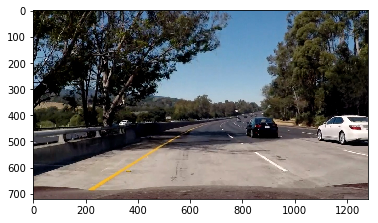

In [13]:
test_image_paths = glob.glob('./test_images/*.jpg')
# Load Image
img_original = cv2.cvtColor(cv2.imread(test_image_paths[4]), cv2.COLOR_BGR2RGB)
plt.imshow(img_original)

#### Crop Image

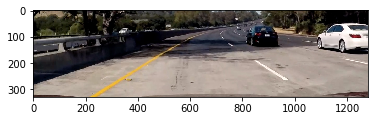

In [14]:
img_cropped = img_original[350:680]

plt.imshow(img_cropped)

#### Calculate Heatmap

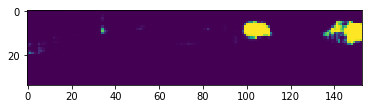

In [15]:
heatmap = get_heatmap(img_cropped)

plt.imshow(heatmap)

#### Scale Heatmap

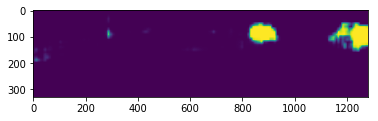

In [16]:
scaled = cv2.resize(heatmap, (img_cropped.shape[1], img_cropped.shape[0]), cv2.INTER_AREA)
scaled = (scaled+1)*0.5

plt.imshow(scaled)

#### Apply Blur

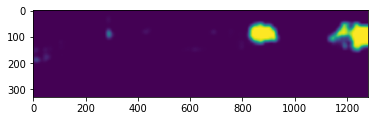

In [17]:
kernel = np.ones((16,16),np.float32)/(16**2)
blur = cv2.filter2D(scaled, -1, kernel)

plt.imshow(blur)

#### Label Blobs

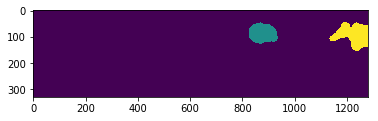

In [18]:
labels = get_labels(blur, thresh=0.8, crop_thresh=0.3)


plt.imshow(labels[0])

#### Calculate Boxes

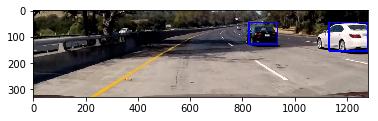

In [19]:
boxes = np.array(get_boxes(labels))
boxed = draw_boxes(img_cropped, boxes)

plt.imshow(boxed)

#### Shift boxes and Draw boxes on original image

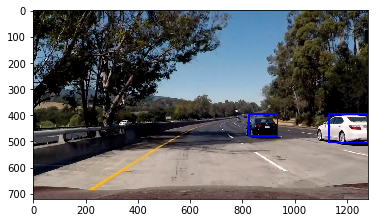

In [20]:
# Shift boxes
boxes[:,:,1] += 350

boxed = draw_boxes(img_original, boxes)

plt.imshow(boxed)

## Pipeline

Bring it all together!  (& and a cache!)

The way the cache works is pretty straight forward, in stead of using the heatmap directly, I use a weighted average over the past 8 frames.

In [23]:
cache_weights = np.linspace(1, 0, num=8)
blur_size = 16

peak_needed = 0.8
valley_between = 0.15

# Values
cache = []

def pipeline(img):
    global cache
    
    img_cropped = img[350:680]

    # Calculate Heatmap
    heatmap = get_heatmap(img_cropped)
    
    # Resize Heatmap
    scaled = cv2.resize(heatmap, (img_cropped.shape[1], img_cropped.shape[0]), cv2.INTER_AREA)
    
    # Scale heatmap between 0 & 1
    scaled = (scaled+1)*0.5
    
    cache.insert(0, scaled)
    cache = cache[:len(cache_weights)]
    
    # Ignore images until cache is filled
    if len(cache) < len(cache_weights):
        return img
    
    # Average cache based on supplied weights
    scaled = np.average(cache, axis=0, weights=cache_weights)
    
    # Blur Heatmap
    kernel = np.ones((blur_size,blur_size),np.float32)/(blur_size**2)
    blur = cv2.filter2D(scaled, -1, kernel)
    
    # Label heatmap
    labels = get_labels(blur, thresh=peak_needed, crop_thresh=valley_between)
    
    # Calculate boxes around labels
    boxes = np.array(get_boxes(labels))
    
    if len(boxes) > 0:
        # Shift boxes to account for cropping
        boxes[:,:,1] += 350

        # Draw Boxes
        boxed = draw_boxes(img, boxes)
    else:
        boxed = img
    return boxed

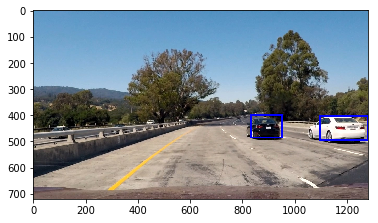

In [24]:
test_image_paths = glob.glob('./test_images/*.jpg')
for _ in range(len(cache_weights)):
    plt.imshow(pipeline(cv2.cvtColor(cv2.imread(test_image_paths[0]), cv2.COLOR_BGR2RGB)))
cache = []

In [25]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip("project_video.mp4")

out_clip = clip.fl_image(pipeline)

out_clip.write_videofile('./output_video.mp4', audio=False)

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


100%|█████████▉| 1260/1261 [06:23<00:00,  3.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 

